# 0: Section Overview

In this section, we will outline how the data necessary to run the regression models is accessed. we will be using the large dataset from "Our World In Data" and augmenting it with various indexes provided by The Oxford Coronavirus Government Response Tracker (OxCGRT) project. We will also complete some Exploratory Data Analysis followed by splitting our final dataset into Test and Training data. 


# 1: Necessary Imports

In [107]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from lightgbm import LGBMRegressor

# 2: Data location

Main Dataset: https://github.com/owid/covid-19-data/tree/master/public/data

This link will take you to a GitHub repository. Within the README.md file within this repository, there is an option to download the complete COVID-19 dataset. Please download the CSV version from the various file type options. 


Index Dataset: https://github.com/OxCGRT/covid-policy-tracker/tree/master/data/timeseries

This link will take you to another GitHub repository, the Oxford Coronavirus Government Response tracker project. From this link, one can download the OxCGRT_timeseries_all.xlsx file within this folder.


# 3: Dataset Augmentation

In order to continue, we need to combine the 2 datasets. In this section we will take the necessary steps to augment the datasets. Note, the augmented test and training datasets are already stored within the GitHub Repository under Train_and_Test_data however we will still show the steps needed to get to these final augmented datasets.

In [66]:
# Load Dataset 1 (e.g., COVID-19 data from Our World in Data)

owid_filepath = r'C:\Users\markm\OneDrive\Documents\University\Year 4\dst\data\our_world_in_data_covid_data.csv' # Enter your file path for the our world in data dataset
ox_index_filepath = r'C:\Users\markm\OneDrive\Documents\University\Year 4\dst\data\OxCGRT_timeseries_all.xlsx' # Enter your file path for the Oxford Coronavirus government response tracker project dataset

df_covid = pd.read_csv(owid_filepath)

# Load Dataset 2 (e.g., Policy Tracker from OxCGRT)
df_policy = pd.read_csv(ox_index_filepath)


In the oxford index dataset, there are many "columns" that we don't require (although in this dataset, the columns are each in their own sheet on the excel). For that reason, let us extract only the columns that we want to keep (these being those containing the various indices that we care about). Additionally, we only want to consider these indices on a national level. Certain countries (for example, Australia or the US) have multiple rows as their state-level data is provided seperately. For that reason, we will filter out those rows and only include rows that contain data on a national jurisdiction level. 

In [68]:
df_stringency = pd.read_excel(ox_index_filepath, sheet_name='stringency_index_avg')
df_containment_health = pd.read_excel(ox_index_filepath, sheet_name='containment_health_index_avg')
df_government_response = pd.read_excel(ox_index_filepath, sheet_name='government_response_index_avg')
df_economic_support = pd.read_excel(ox_index_filepath, sheet_name='economic_support_index')

# List of the dataframes to process
indexes = [df_stringency, df_containment_health, df_government_response, df_economic_support]
filtered_indexes = []

# Filter each dataframe and store the filtered version in 'filtered_indexes'
for df in indexes:
    filtered_df = df[df['jurisdiction'] == 'NAT_TOTAL']
    filtered_indexes.append(filtered_df)

# Assign the filtered dataframes back to their original variables (optional)
df_stringency, df_containment_health, df_government_response, df_economic_support = filtered_indexes

# Save the filtered dataframes as separate CSV files
# df_stringency.to_csv('stringency_index',index=False)
# df_containment_health.to_csv('containment_health_filtered.csv', index=False)
# df_government_response.to_csv('government_response_filtered.csv', index=False)
# df_economic_support.to_csv('economic_support_filtered.csv', index=False)


In [69]:
df_containment_health.head()

,country_code,country_name,region_code,region_name,jurisdiction,01Jan2020,02Jan2020,03Jan2020,04Jan2020,05Jan2020,...,11Feb2023,12Feb2023,13Feb2023,14Feb2023,15Feb2023,16Feb2023,17Feb2023,18Feb2023,19Feb2023,20Feb2023
0,ABW,Aruba,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AGO,Angola,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALB,Albania,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AND,Andorra,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, we have separated each index into its own dataframe. Our main problem is that unlike the OWID dataset where date is one column and there are multiple rows per country, the Oxford dataset has each date as is its own column and a singular row for a country. We need to reformat this so that it matches the format of the OWID dataset so that it can then be used in the model. To do this, we define the following function:

In [70]:
def transposer(dataset,index_name):
    # Create a complete date range from January 5, 2020, to August 4, 2024 - this datarange matches that of each country in the OWID dataset
    date_range = pd.date_range(start='05-Jan-2020', end='04-Aug-2024', freq='D')
    complete_dates_df = pd.DataFrame(date_range, columns=['date'])  # Create a DataFrame with all dates

# Create a list to store the complete DataFrames for each country
    complete_dataframes = []

# Iterate through each row in df_containment_health
    for row_index in range(dataset.shape[0]):  # Iterate through rows
        # Select the row you want to transpose (excluding first 9 columns) - we want to start on 05-Jan-2020
        row_to_transpose = dataset.iloc[row_index][9:]  # Adjust index as needed
        transposed_row = row_to_transpose.transpose()  # Transpose the row

         # Convert the transposed row to a DataFrame
        transposed_df = pd.DataFrame(transposed_row).reset_index()
        transposed_df.columns = ['date', index_name+'_' + 'Index']  # Rename columns for clarity

         # Ensure the 'Date' column is in datetime format
        transposed_df['date'] = pd.to_datetime(transposed_df['date'], format='%d%b%Y')

        # Merge with the complete date range DataFrame
        complete_df = complete_dates_df.merge(transposed_df, on='date', how='left')

        # Add a new column for country code or name if needed
        complete_df['iso_code'] = dataset.iloc[row_index, 0]  # Assuming the first column is the country code/name

        # Append the complete DataFrame for this country to the list
        complete_dataframes.append(complete_df)

# Concatenate all the DataFrames in the list into a single DataFrame
    final_df = pd.concat(complete_dataframes, ignore_index=True)
    return final_df

Let us look at what this function does to one of our dataframes.

In [72]:
transposed_containment_health = transposer(df_containment_health, 'CH')

print('Before Transposing')
df_containment_health.head()




Before Transposing


,country_code,country_name,region_code,region_name,jurisdiction,01Jan2020,02Jan2020,03Jan2020,04Jan2020,05Jan2020,...,11Feb2023,12Feb2023,13Feb2023,14Feb2023,15Feb2023,16Feb2023,17Feb2023,18Feb2023,19Feb2023,20Feb2023
0,ABW,Aruba,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AGO,Angola,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALB,Albania,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AND,Andorra,NaN,NaN,NAT_TOTAL,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
print('After Transposing')
transposed_containment_health.head()

After Transposing


,date,CH_Index,iso_code
0,2020-01-05,0.0,ABW
1,2020-01-06,0.0,ABW
2,2020-01-07,0.0,ABW
3,2020-01-08,0.0,ABW
4,2020-01-09,0.0,ABW


Great! So now our data looks more similar to the data within the OWID dataset. Let's run this function on the remaining index datasets.

In [74]:
transposed_stringency = transposer(df_stringency,'Stringency')
transposed_government_response = transposer(df_government_response, 'Gov_Resp')
transposed_economic_support = transposer(df_economic_support, 'Econ_Sup')

Let us now combine all of these into a singular dataframe - namely, df_combined. Note that the iso_code and date columns will be used together as a composite primary key to differentiate between rows. 

In [76]:
df_combined = transposed_stringency.join(transposed_containment_health, how='inner', lsuffix='', rsuffix='_containment')
df_combined = df_combined.join(transposed_government_response, how='inner', lsuffix='_df_combined', rsuffix='_govresp')
df_combined = df_combined.join(transposed_economic_support, how='inner', lsuffix='_df_combined', rsuffix='_econsup')
# # Select only the desired columns
df_combined = df_combined[['date', 'iso_code', 'Stringency_Index', 'CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index']]
# Display the result - test output
df_combined[df_combined['Stringency_Index'] != 0]

,date,iso_code,Stringency_Index,CH_Index,Gov_Resp_Index,Econ_Sup_Index
71,2020-03-16,ABW,11.11,9.52,8.33,0.0
72,2020-03-17,ABW,22.22,16.67,14.58,0.0
73,2020-03-18,ABW,33.33,26.19,22.92,0.0
74,2020-03-19,ABW,33.33,29.76,26.04,0.0
75,2020-03-20,ABW,33.33,29.76,26.04,0.0
...,...,...,...,...,...,...
313033,2024-07-31,ZWE,NaN,NaN,NaN,NaN
313034,2024-08-01,ZWE,NaN,NaN,NaN,NaN
313035,2024-08-02,ZWE,NaN,NaN,NaN,NaN
313036,2024-08-03,ZWE,NaN,NaN,NaN,NaN


Now we need to make sure our OWID dataset is in the appropriate format to combine with the Oxford dataset. First we will reformat the date column.

In [77]:
df_covid['date'] = pd.to_datetime(df_covid['date'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

In [79]:
df_covid['date'].head()

0    2020-01-05
1    2020-01-06
2    2020-01-07
3    2020-01-08
4    2020-01-09
Name: date, dtype: object

Besides this, the OWID dataset looks ready to be augmented with the indices we specified from the Oxford dataset.

In [80]:
# Ensure the OWID dataset's date column is in datetime format
df_covid['date'] = pd.to_datetime(df_covid['date'], format='%Y-%m-%d', errors='coerce')

# Ensure your other dataset's date column is also in datetime format (assuming it's named 'date')
df_combined['date'] = pd.to_datetime(df_combined['date'], format='%Y-%m-%d', errors='coerce')

# Now perform the merge (assuming 'date' and 'iso_code' are the keys)
merged_df = pd.merge(df_combined, df_covid, on=['iso_code', 'date'], how='inner')

# Check the merged dataframe
merged_df.head()


,date,iso_code,Stringency_Index,CH_Index,Gov_Resp_Index,Econ_Sup_Index,continent,location,total_cases,new_cases,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,2020-01-05,ABW,0.0,0.0,0.0,0.0,North America,Aruba,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN
1,2020-01-06,ABW,0.0,0.0,0.0,0.0,North America,Aruba,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN
2,2020-01-07,ABW,0.0,0.0,0.0,0.0,North America,Aruba,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN
3,2020-01-08,ABW,0.0,0.0,0.0,0.0,North America,Aruba,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN
4,2020-01-09,ABW,0.0,0.0,0.0,0.0,North America,Aruba,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN


In [81]:
merged_df.columns

Index(['date', 'iso_code', 'Stringency_Index', 'CH_Index', 'Gov_Resp_Index',
       'Econ_Sup_Index', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_b

Note, we do have 2 columns, Stringency_Index and stringency_index. Whilst this is not a large problem, it can be observed that they are not exactly numerically equivalenet. The below code displays row where these columns differ in their value. It is not an easy to decide on which column to use. On the one hand, it may be better to use the initial column since we have used it in previous analysis and it comes from our initial OWID dataset. However, the augmented column has more documentation and specific insight into how it was calculated and can therefore could provide a more reliable figure. For these reasons we will just take a mean average of these 2 columns and use this. 

In [83]:
mask = merged_df['Stringency_Index'] != merged_df['stringency_index']

# Step 2: Filter the DataFrame using the mask
differences = merged_df[mask][['date','Stringency_Index','stringency_index','iso_code']].dropna()

# test = differences[['stringency_index', 'Stringency Index']].mean(axis=1)
# print(test)

# Display the rows where the values differ
print("Rows where Column_A and Column_B differ:")

differences

Rows where Column_A and Column_B differ:


,date,Stringency_Index,stringency_index,iso_code
2326,2021-10-18,38.89,36.11,AFG
2327,2021-10-19,38.89,36.11,AFG
2328,2021-10-20,38.89,36.11,AFG
2329,2021-10-21,38.89,36.11,AFG
2330,2021-10-22,38.89,36.11,AFG
...,...,...,...,...
309280,2022-12-27,8.33,13.89,ZMB
309281,2022-12-28,8.33,13.89,ZMB
309282,2022-12-29,8.33,13.89,ZMB
309283,2022-12-30,8.33,13.89,ZMB


In [84]:
# Step 1: Calculate the mean and add it back to the original DataFrame
merged_df['Mean_Stringency_Index'] = merged_df[['Stringency_Index', 'stringency_index']].mean(axis=1, skipna=True)

# Step 2: Apply the filtering conditions on the original DataFrame
selected_row_mean_check = merged_df.loc[(merged_df['date'] == '2021-10-18') & (merged_df['iso_code'] == 'AFG'), 'Mean_Stringency_Index']

# Display the result
print(selected_row_mean_check)


merged_df = merged_df.drop(columns=['Stringency_Index'])
merged_df = merged_df.drop(columns=['stringency_index'])



2326    37.5
Name: Mean_Stringency_Index, dtype: object


The above block takes the average of the two columns for some row. We can check it is working by computing the average by hand for some row and checking it is the same provided above.

Let us move the continent and location columns to the front.

In [85]:
all_columns = list(merged_df.columns)
# Move 'continent' and 'location' next to 'date' and 'iso_code'
new_column_order = ['date', 'iso_code', 'continent', 'location', 'Mean_Stringency_Index'] + [col for col in all_columns if col not in ['date', 'iso_code', 'continent', 'location','Mean_Stringency_Index']]
merged_df = merged_df[new_column_order]
merged_df.head()

,date,iso_code,continent,location,Mean_Stringency_Index,CH_Index,Gov_Resp_Index,Econ_Sup_Index,total_cases,new_cases,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,2020-01-05,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN
1,2020-01-06,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN
2,2020-01-07,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN
3,2020-01-08,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN
4,2020-01-09,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,76.29,NaN,106459,NaN,NaN,NaN,NaN


We now need to add an additional column to the dataset. this column will be called days_since. This column will effectively represent the date column in our future regression models however these models do not interpret timestamp objects and we will get an error that looks like this:

TypeError: float() argument must be a string or a real number, not 'Timestamp'

Hence this new column is necessary.

In [89]:
merged_df['days_since'] = merged_df.groupby('iso_code')['date'].transform(lambda x: (x - x.min()).dt.days)

This column will start at 0 (representing the first day of recording, the 5th of January 2020) and end at 1673 (representing the last day of recording, the 4th of August 2023)

In [90]:
print(merged_df.columns)

Index(['date', 'iso_code', 'continent', 'location', 'Mean_Stringency_Index',
       'CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index', 'total_cases',
       'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'to

# 4. Exploratory Data Analysis

In this section, we will explore our newly augmented dataset through exploratory data analysis. This will help use to understand the relationships between the covariate variable features and our target variable, namely, the total vaccinations per hundred.



## Plot 1: Line Graph of normalised total vaccinations over the time period

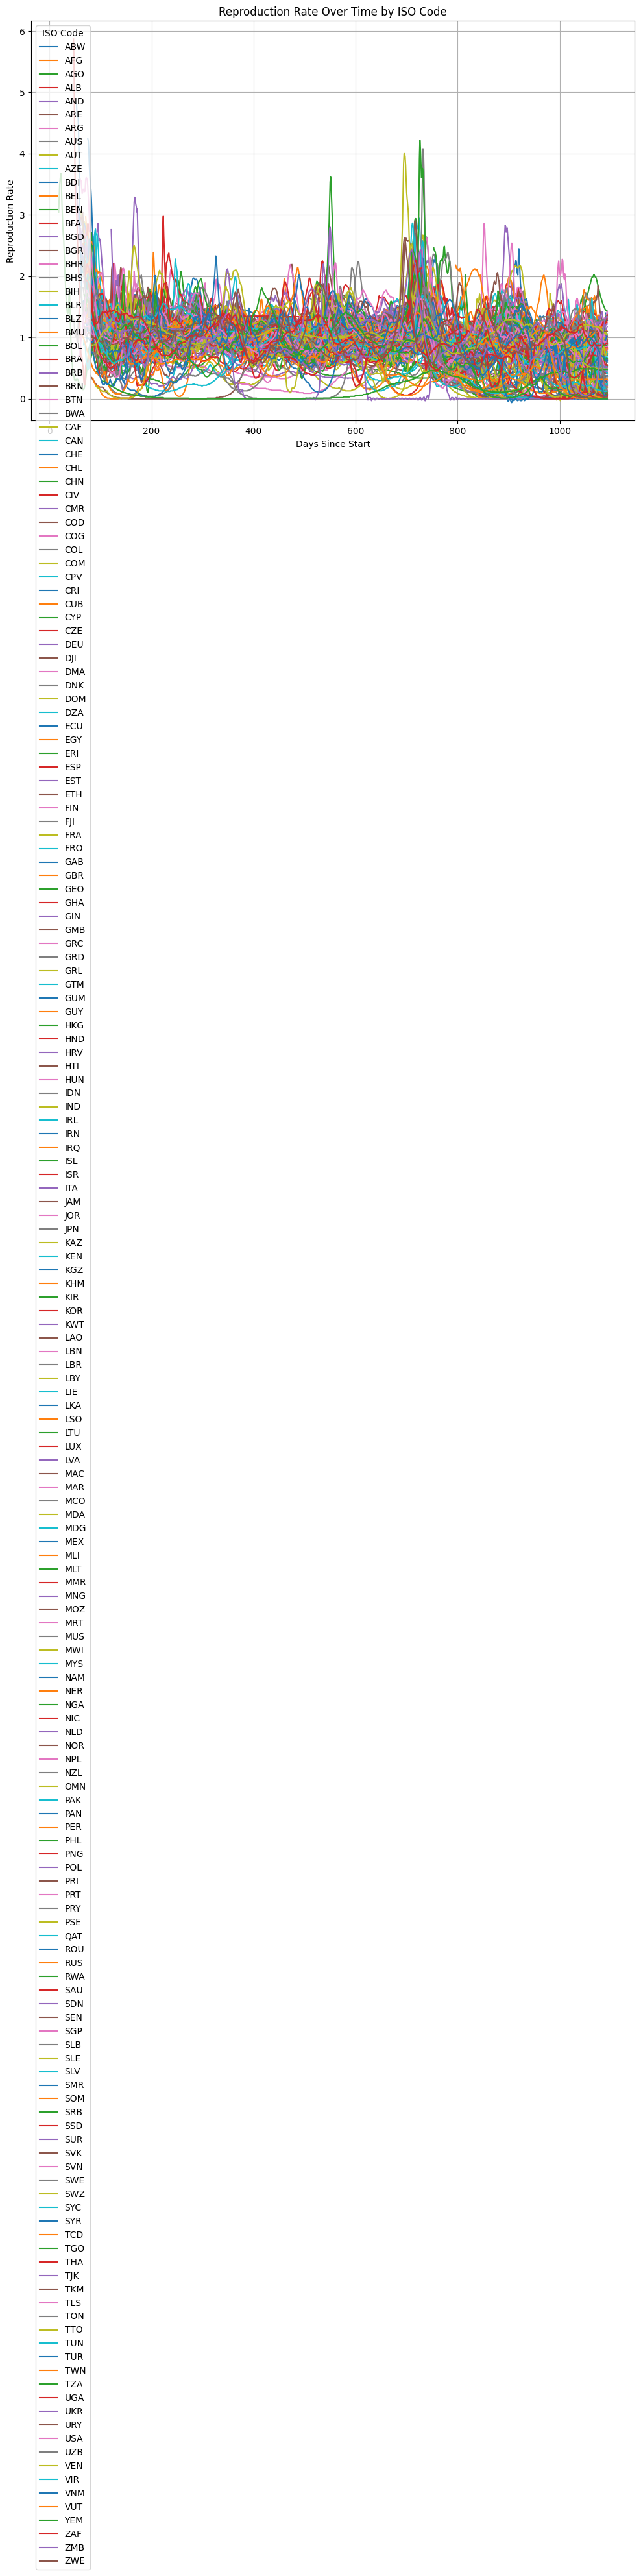

In [93]:

# Assuming you have 'days_since', 'total_vaccinations_per_hundred', and 'iso_code' in your dataset
plt.figure(figsize=(12, 8))

# Loop through each unique iso_code and plot for each one
for iso in merged_df['iso_code'].unique():
    subset = merged_df[merged_df['iso_code'] == iso]
    plt.plot(subset['days_since'], subset['reproduction_rate'], label=iso)

# Add title and labels
plt.title('Reproduction Rate Over Time by ISO Code')
plt.xlabel('Days Since Start')
plt.ylabel('Reproduction Rate')

# Show legend and grid
plt.legend(title='ISO Code')
plt.grid(True)

# Show the plot
plt.show()


Since we have included all the countries' data for this plot, the legend is incredibly large. Let's randomely select a subset of countries such that this does not happen.

### Reducing the number of countries displayed on Plot 1

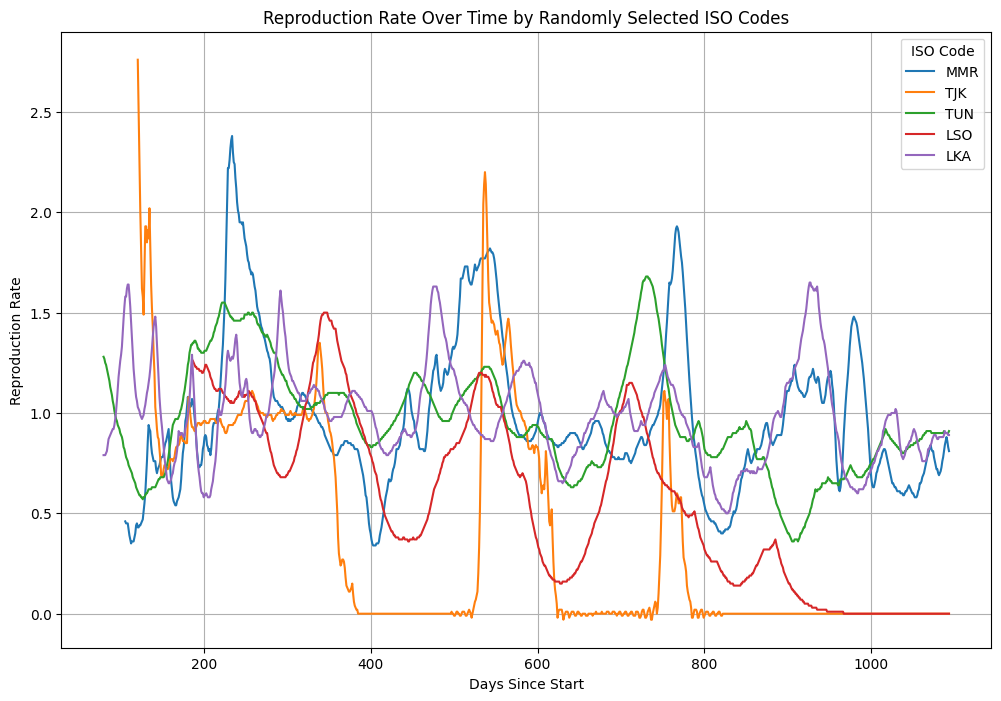

In [98]:
# Get unique ISO codes and randomly sample 20 of them
random_iso_codes = merged_df['iso_code'].unique()
random_selected_iso_codes = pd.Series(random_iso_codes).sample(n=5, random_state=42).tolist()

plt.figure(figsize=(12, 8))

# Loop through the randomly selected ISO codes and plot for each one
for iso in random_selected_iso_codes:
    subset = merged_df[merged_df['iso_code'] == iso]
    plt.plot(subset['days_since'], subset['reproduction_rate'], label=iso)

# Add title and labels
plt.title('Reproduction Rate Over Time by Randomly Selected ISO Codes')
plt.xlabel('Days Since Start')
plt.ylabel('Reproduction Rate')

# Show legend and grid
plt.legend(title='ISO Code')
plt.grid(True)

# Show the plot
plt.show()


Analysis

## Plot 2: Scatter Graph of response variable against Independent Variables

### Data preprocessing

We were getting the following error: ValueError: cannot reindex on an axis with duplicate labels. This is due to the fact that when we've aggregated our train and test dataset back together, we have duplicated index values for each row up to the final row of the test data (the smaller of the two datasets). i.e. both first rows of each dataset are indexed 0, the second rows of each are both indexed 1 (and so on). Hence we just need to perform a simple index reset.

In [99]:
combined_w_string_cols = merged_df.reset_index(drop=True)

For the same reasons as plot 1, we will display only a randomely selected few iso_codes on the plot.

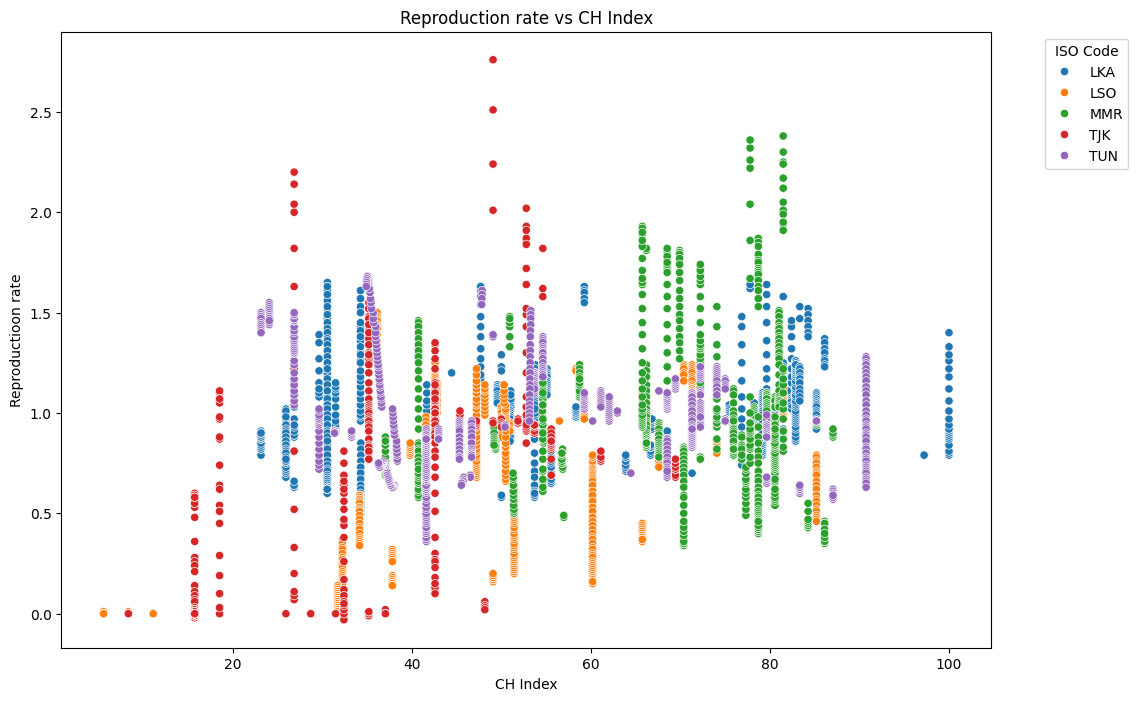

In [101]:
# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df[merged_df['iso_code'].isin(random_selected_iso_codes)], x='Mean_Stringency_Index', y='reproduction_rate', hue='iso_code')

# Set plot title and labels
plt.title('Reproduction rate vs CH Index')  # Update title to reflect correct x-axis
plt.xlabel('CH Index')  # Update x-label to reflect actual data
plt.ylabel('Reproductioon rate')

# Display legend and show plot
plt.legend(title='ISO Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Analysis

## Plot 3: Pair Plot

This Pair Plot is an extention of the previous plot. We can use the pair plot To visually inspect the relationships between covariates and the reproduction rate, especially useful for identifying non-linear relationships or interactions.

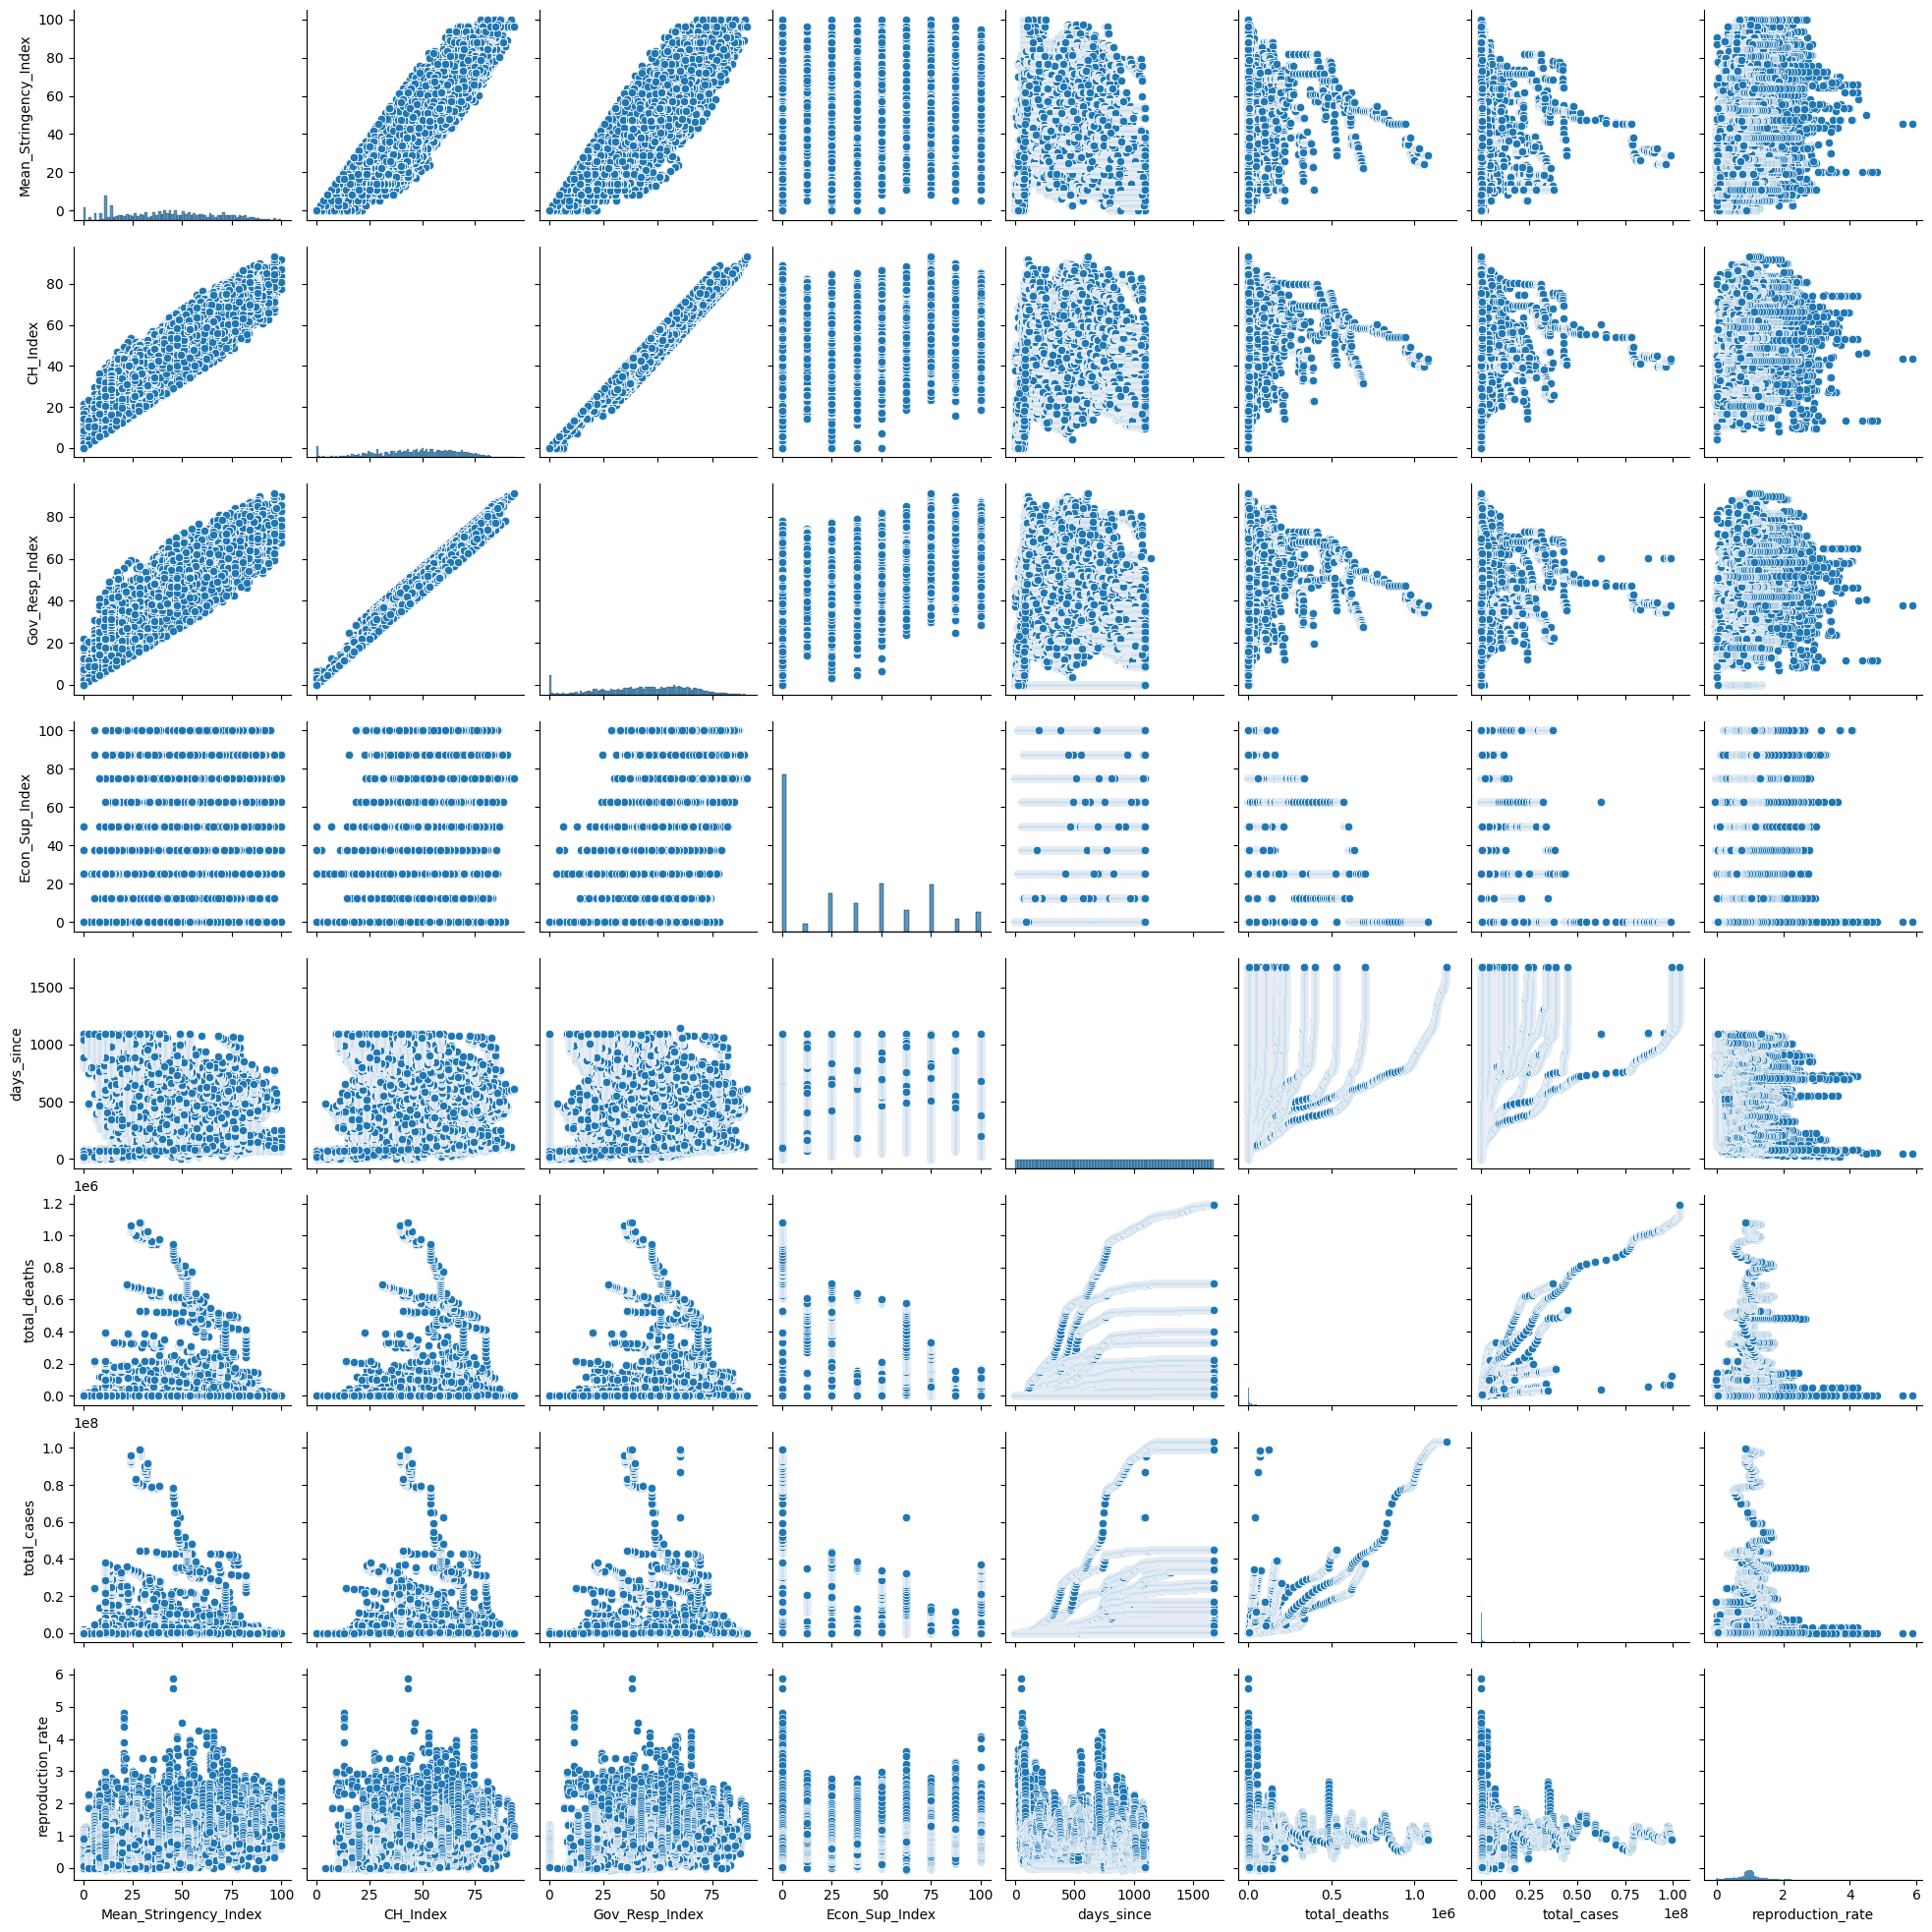

In [102]:
c = ['Mean_Stringency_Index','CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index','days_since','total_deaths','total_cases', 'reproduction_rate']
sns.pairplot(combined_w_string_cols, vars=c)
plt.show()

## Plot 4: Correlation Matrix and Heatmap

To check linear relationships between covariates and the reproduction rate

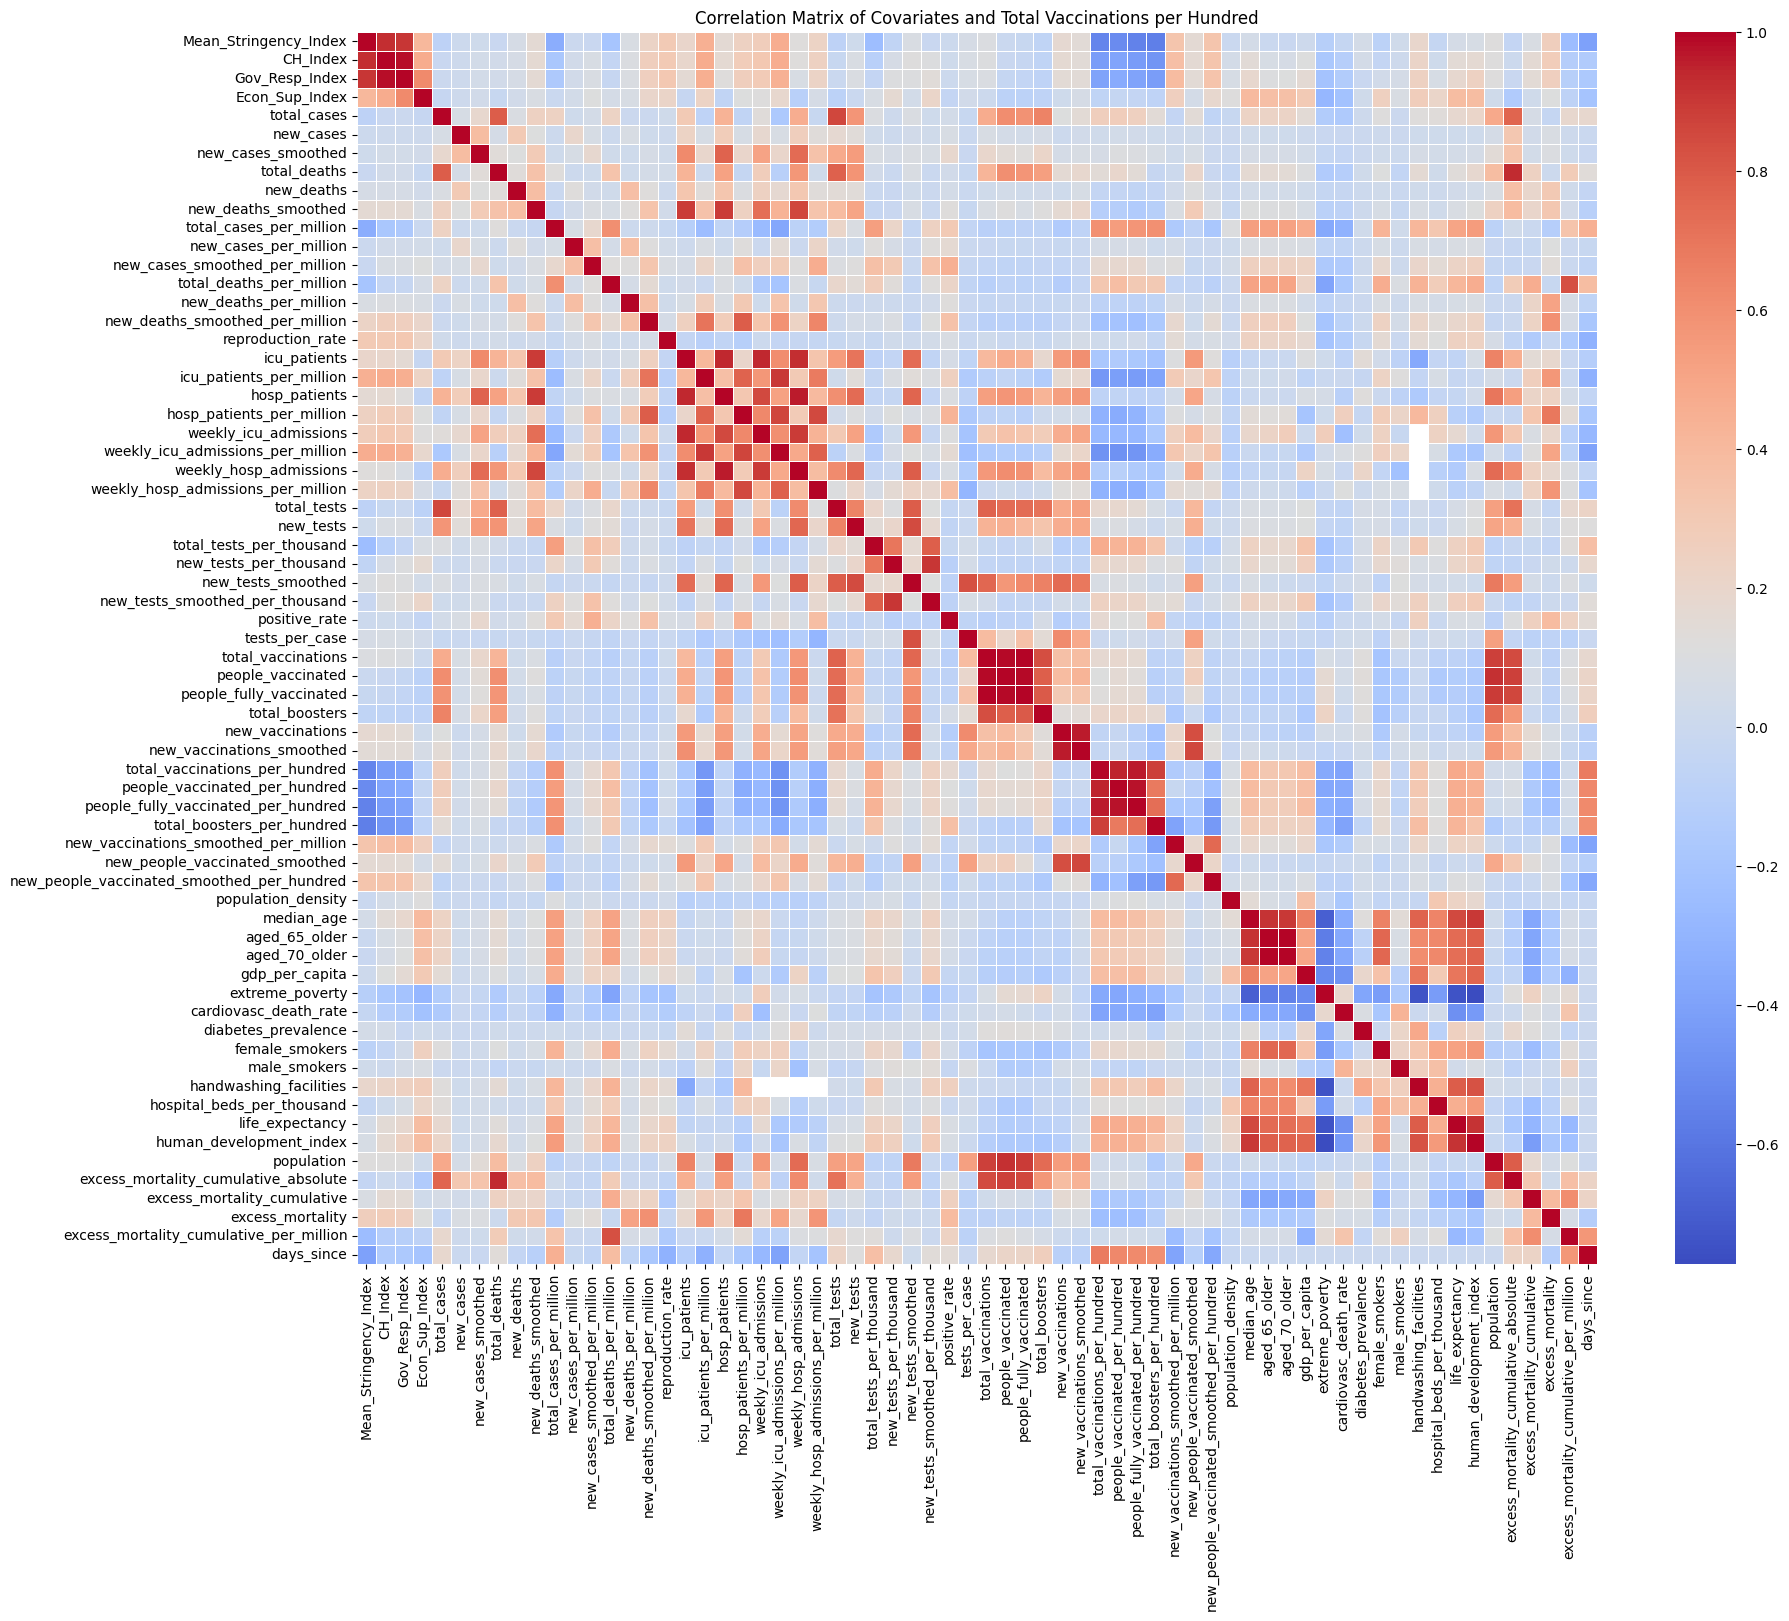

In [103]:
merged_df_no_string_columns = merged_df.iloc[:, 4:]
merged_df_for_correl_matrix = merged_df_no_string_columns.drop(columns=['tests_units'])
#print(combined.columns)

plt.figure(figsize=(20, 16))
sns.heatmap(merged_df_for_correl_matrix.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Covariates and Total Vaccinations per Hundred")
plt.show()

# 5. Data Cleaning

To ensure that each model that we impliment uses the same test and training datasets, we will clean the data here. In the following section of this document (6: Splitting our Data into Training and Testing Data), we will upload the test and training files that will then be accessed for the running of each model. In this section we will structure our training and testing data such that:

1. Only the relevant columns will be included.

2. Missing Data rows are dealt with i.e. ...

## 1. Selecting Columns

So, to recap, these are the columns of our complete dataset.

In [104]:
merged_df.columns

Index(['date', 'iso_code', 'continent', 'location', 'Mean_Stringency_Index',
       'CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index', 'total_cases',
       'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'to

In [106]:
columns_to_keep = ['date', 'iso_code', 'continent', 'location', 'Mean_Stringency_Index','CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index', 'total_cases',
       'new_cases', 'total_deaths', 'new_deaths', 'reproduction_rate','icu_patients','hosp_patients','total_tests', 'new_tests','total_vaccinations', 'new_vaccinations','days_since']
refined_columns_dataset = merged_df[columns_to_keep]
refined_columns_dataset

,date,iso_code,continent,location,Mean_Stringency_Index,CH_Index,Gov_Resp_Index,Econ_Sup_Index,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,new_tests,total_vaccinations,new_vaccinations,days_since
0,2020-01-05,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2020-01-06,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2020-01-07,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,2020-01-08,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,2020-01-09,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311536,2024-07-31,ZWE,Africa,Zimbabwe,NaN,NaN,NaN,NaN,266386.0,0.0,5740.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1669
311537,2024-08-01,ZWE,Africa,Zimbabwe,NaN,NaN,NaN,NaN,266386.0,0.0,5740.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1670
311538,2024-08-02,ZWE,Africa,Zimbabwe,NaN,NaN,NaN,NaN,266386.0,0.0,5740.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1671
311539,2024-08-03,ZWE,Africa,Zimbabwe,NaN,NaN,NaN,NaN,266386.0,0.0,5740.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1672


## 2. Dealing with missing Data

We thought it was important to consider the missing data within our dataset. First we used the missingno library to visualise the mising data within our dataset.



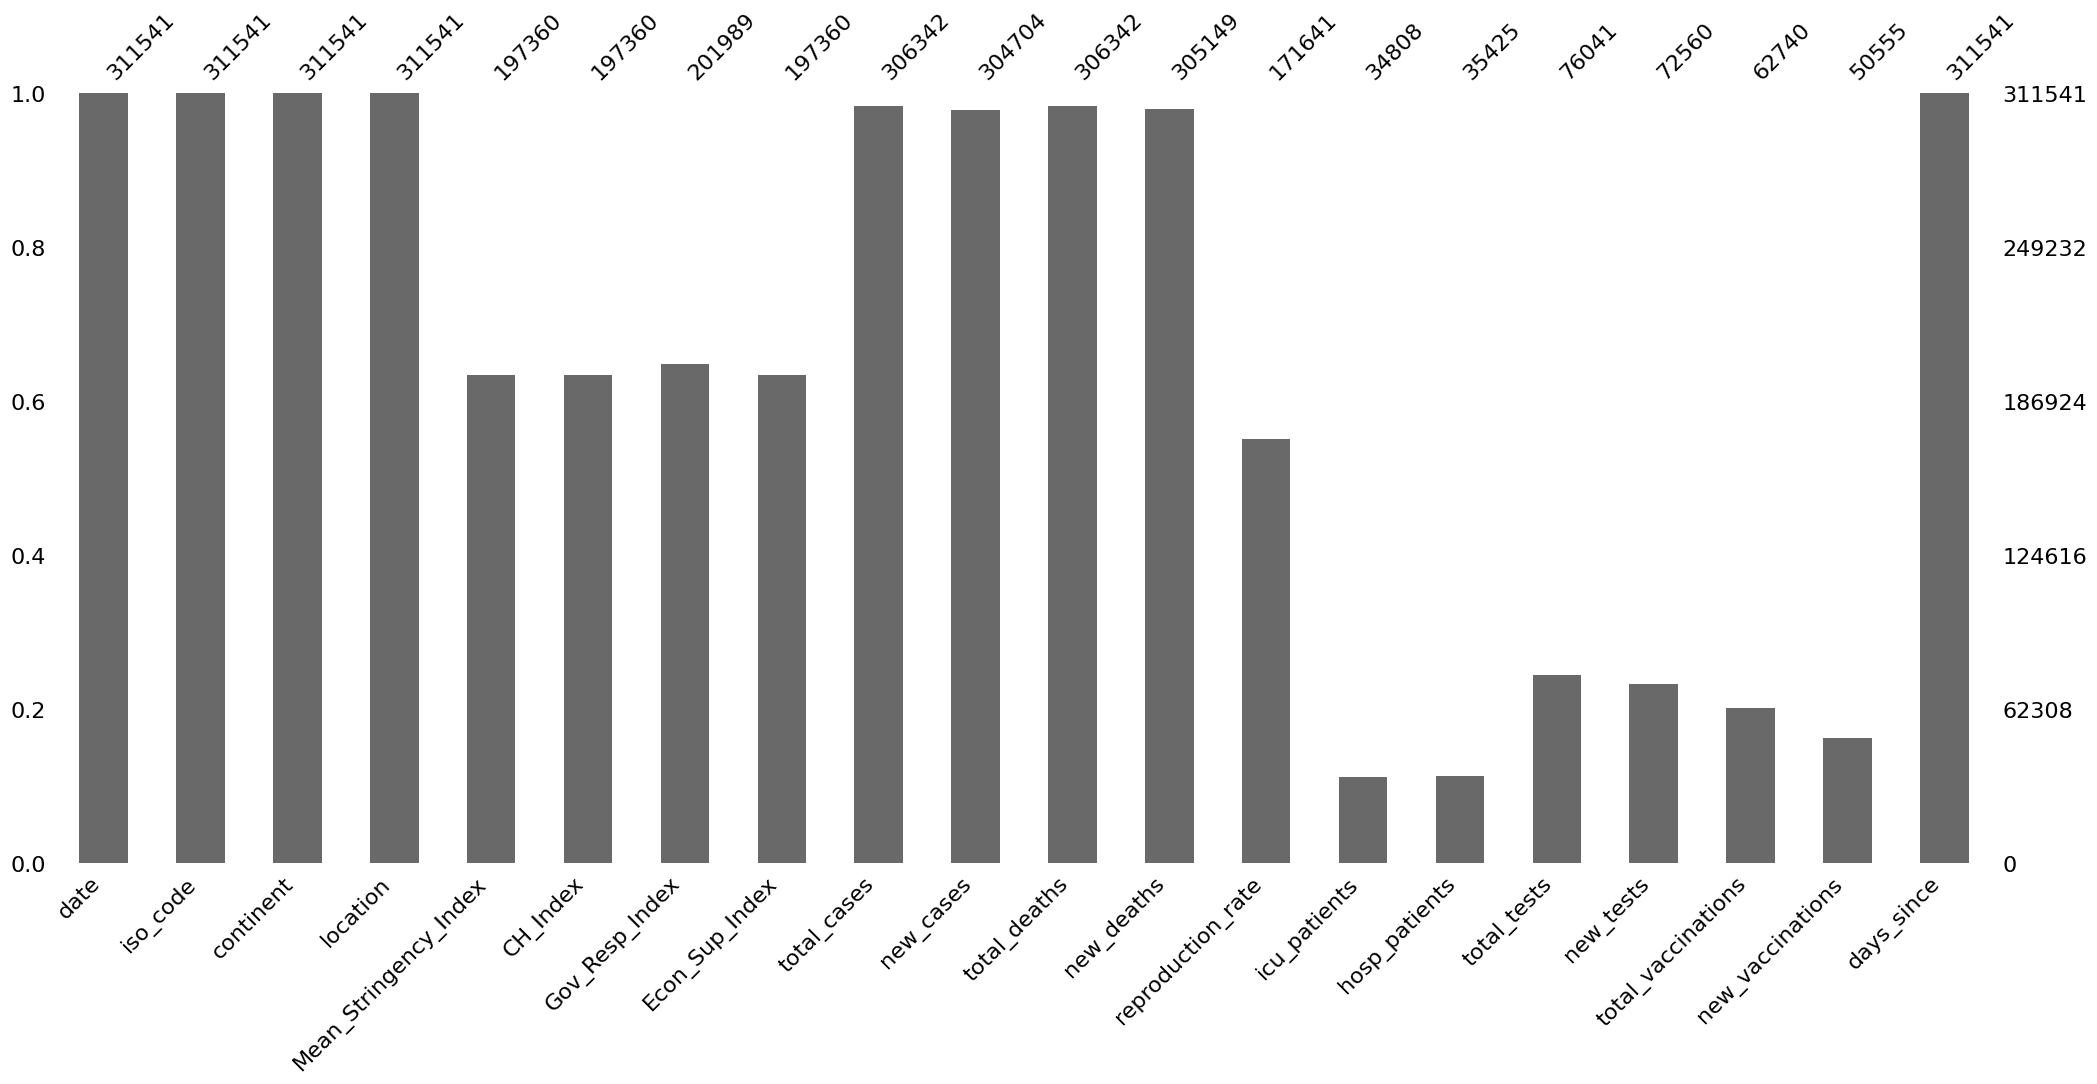

In [108]:
msno.bar(merged_df[columns_to_keep])
plt.show()

let's focus on data we have THE index values for. The index values stop at the end of 2022 hence we will cut our dataset off at this point in time.

In [109]:
end_date = pd.to_datetime('2022-12-31')
refined_with_date = refined_columns_dataset[refined_columns_dataset['date'] <= end_date]
refined_with_date

,date,iso_code,continent,location,Mean_Stringency_Index,CH_Index,Gov_Resp_Index,Econ_Sup_Index,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,new_tests,total_vaccinations,new_vaccinations,days_since
0,2020-01-05,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2020-01-06,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2020-01-07,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,2020-01-08,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,2020-01-09,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310954,2022-12-27,ZWE,Africa,Zimbabwe,53.7,57.96,50.72,0.0,259944.0,0.0,5635.0,0.0,0.02,NaN,NaN,NaN,NaN,NaN,NaN,1087
310955,2022-12-28,ZWE,Africa,Zimbabwe,53.7,57.96,50.72,0.0,259944.0,0.0,5635.0,0.0,0.03,NaN,NaN,NaN,NaN,NaN,NaN,1088
310956,2022-12-29,ZWE,Africa,Zimbabwe,53.7,57.96,50.72,0.0,259944.0,0.0,5635.0,0.0,0.03,NaN,NaN,NaN,NaN,NaN,NaN,1089
310957,2022-12-30,ZWE,Africa,Zimbabwe,53.7,57.96,50.72,0.0,259944.0,0.0,5635.0,0.0,0.03,NaN,NaN,NaN,NaN,NaN,NaN,1090


imputation - MICE

In [110]:
# List of columns to keep for imputation
columns_to_exclude = ['date', 'iso_code', 'continent', 'location']

# Filter columns by excluding the ones in 'columns_to_exclude'
imputation_cols = [col for col in refined_with_date.columns if col not in columns_to_exclude]

# Use IterativeImputer (which implements MICE) for multiple imputation
imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=21)

# Apply the imputer to the dataset (ignoring the 'date' column)
df_imputed_MICE = pd.DataFrame(imputer.fit_transform(refined_with_date[imputation_cols]), columns=imputation_cols)

df_imputed_MICE = pd.concat([refined_with_date[columns_to_exclude].reset_index(drop=True), df_imputed_MICE.reset_index(drop=True)], axis=1)

new_column_order = ['date', 'iso_code', 'continent', 'location'] + [col for col in refined_with_date.columns if col not in ['date', 'iso_code', 'continent', 'location']]
df_imputed_MICE = df_imputed_MICE[new_column_order]
df_imputed_MICE.head()

C:\Users\markm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,date,iso_code,continent,location,Mean_Stringency_Index,CH_Index,Gov_Resp_Index,Econ_Sup_Index,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,new_tests,total_vaccinations,new_vaccinations,days_since
0,2020-01-05,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.912242,161.809579,1048.540191,-2.936716e+07,-114392.144081,-3.163072e+08,-348015.139348,0.0
1,2020-01-06,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.911840,162.142648,1049.491513,-2.934751e+07,-114326.411615,-3.159684e+08,-347918.259832,1.0
2,2020-01-07,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.911437,162.475717,1050.442836,-2.932786e+07,-114260.679149,-3.156297e+08,-347821.380316,2.0
3,2020-01-08,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.911035,162.808786,1051.394158,-2.930821e+07,-114194.946683,-3.152909e+08,-347724.500800,3.0
4,2020-01-09,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.910632,163.141855,1052.345480,-2.928855e+07,-114129.214217,-3.149522e+08,-347627.621284,4.0


In [111]:
# List of columns to keep for imputation
columns_to_exclude = ['date', 'iso_code', 'continent', 'location']

# Filter columns by excluding the ones in 'columns_to_exclude'
imputation_cols = [col for col in refined_with_date.columns if col not in columns_to_exclude]

# Use IterativeImputer (which implements LGBM)
imputer = IterativeImputer(estimator=LGBMRegressor(), max_iter=10, random_state=21)

# Apply the imputer to the dataset (ignoring the 'date' column)
df_imputed_LGBM = pd.DataFrame(imputer.fit_transform(refined_with_date[imputation_cols]), columns=imputation_cols)

df_imputed_LGBM = pd.concat([refined_with_date[columns_to_exclude].reset_index(drop=True), df_imputed_LGBM.reset_index(drop=True)], axis=1)

new_column_order = ['date', 'iso_code', 'continent', 'location'] + [col for col in refined_with_date.columns if col not in ['date', 'iso_code', 'continent', 'location']]
df_imputed_LGBM = df_imputed_LGBM[new_column_order]
df_imputed_LGBM.head()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3568
[LightGBM] [Info] Number of data points in the train set: 203757, number of used features: 15
[LightGBM] [Info] Start training from score 545.484916
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3568
[LightGBM] [Info] Number of data points in the train set: 201938, number of used features: 15
[LightGBM] [Info] Start training from score 44.128081
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

C:\Users\markm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,date,iso_code,continent,location,Mean_Stringency_Index,CH_Index,Gov_Resp_Index,Econ_Sup_Index,total_cases,new_cases,total_deaths,new_deaths,reproduction_rate,icu_patients,hosp_patients,total_tests,new_tests,total_vaccinations,new_vaccinations,days_since
0,2020-01-05,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.916218,729.113199,5145.737495,1.561880e+08,594924.982129,2.395231e+08,4.568658e+06,0.0
1,2020-01-06,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.916218,729.113199,5145.737495,1.561880e+08,594924.982129,2.395231e+08,4.568658e+06,1.0
2,2020-01-07,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.916218,729.113199,5145.737495,1.561880e+08,594924.982129,2.395231e+08,4.568658e+06,2.0
3,2020-01-08,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.916218,729.113199,5145.737495,1.561880e+08,594924.982129,2.395231e+08,4.568658e+06,3.0
4,2020-01-09,ABW,North America,Aruba,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.916218,729.113199,5145.737495,1.561880e+08,594924.982129,2.395231e+08,4.568658e+06,4.0


I have some reservations about the imputation methods used for handling the missing data in our dataset. The replacements provided do not seem to be reasonable. For one, the multiple imputation method imputed several values as large and negative in cases where data was strictly positive e.g. new_tests. Similarly the LGBM method seemed equally unreliable, offering imputed values that seemed unrealistic (e.g.2.395231e+08 total vaccinations on the first day of recording for Aruba prior to any deaths recorded.) Additionally, the imputation methods seemed to differ in cases such as the reproduction_rate where, the MICE method estimated a reproduction rate of 0.912242 on the first day of recording for ARUBA whereas the LGBM estimated 2.916218. 

Uncertainty around whether the methods were reliable on this particular dataset meant that we were inclined to avoid implimenting imputation and instead we elected to just select those rows without missing data. Fortunately the dataset was sufficiently large to do this. 
Implementing listwise deletion where rows with any missing data are removed presents a problem in itself, namely a trade-off between the number of covariates included in our model and the size of our training and testing datasets.

As we add more covariates (independent variables) to our model, we increase the likelihood of encountering missing data within those variables. This can lead to a higher number of rows being excluded from the analysis. Consequently, using listwise deletion can significantly reduce our sample size, as any row with a missing value across any of the included covariates will be removed. Hence there is a tradeoff as while having more covariates can enhance the model's ability to capture complex relationships and improve predictive accuracy, it simultaneously risks reducing the available data for training and testing. Additionally, these included covariates may not be statistically significant in improving the model performance to warrant their inclusion at all in the model. Hence we decided to refine our relevant covariates to include as much of the sample data as possible.



In [112]:
chosen_cleaned_dataset = refined_with_date
chosen_columns = ['date','iso_code','continent','location','Mean_Stringency_Index','CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index','days_since','total_cases','total_deaths','new_cases','new_deaths','reproduction_rate']
final_dataset = chosen_cleaned_dataset[chosen_columns].dropna()
final_dataset

,date,iso_code,continent,location,Mean_Stringency_Index,CH_Index,Gov_Resp_Index,Econ_Sup_Index,days_since,total_cases,total_deaths,new_cases,new_deaths,reproduction_rate
1758,2020-03-29,AFG,Asia,Afghanistan,67.59,55.36,48.44,0.0,84,91.0,2.0,67.0,2.0,1.51
1759,2020-03-30,AFG,Asia,Afghanistan,67.59,55.36,48.44,0.0,85,91.0,2.0,0.0,0.0,1.51
1760,2020-03-31,AFG,Asia,Afghanistan,67.59,55.36,48.44,0.0,86,91.0,2.0,0.0,0.0,1.52
1761,2020-04-01,AFG,Asia,Afghanistan,67.59,55.36,48.44,0.0,87,91.0,2.0,0.0,0.0,1.51
1762,2020-04-02,AFG,Asia,Afghanistan,67.59,55.36,48.44,0.0,88,91.0,2.0,0.0,0.0,1.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310954,2022-12-27,ZWE,Africa,Zimbabwe,53.7,57.96,50.72,0.0,1087,259944.0,5635.0,0.0,0.0,0.02
310955,2022-12-28,ZWE,Africa,Zimbabwe,53.7,57.96,50.72,0.0,1088,259944.0,5635.0,0.0,0.0,0.03
310956,2022-12-29,ZWE,Africa,Zimbabwe,53.7,57.96,50.72,0.0,1089,259944.0,5635.0,0.0,0.0,0.03
310957,2022-12-30,ZWE,Africa,Zimbabwe,53.7,57.96,50.72,0.0,1090,259944.0,5635.0,0.0,0.0,0.03


# 6: Splitting our Data into Training and Testing Data

Now we are going to split our data up into test and training data. Due to the nature of this particular project where we are aiming to predict the reproduction rate for a particular country over the entire period of time, it makes intuitive sense to due a train/test split on a country level i.e. we aren't going to design a split such that some of a country's data is in training and some of it is in testing. 

Let us first see how many countries there are in our dataset.

In [113]:
print(final_dataset['iso_code'].unique())
print(len(final_dataset['iso_code'].unique()))



['AFG' 'AGO' 'ALB' 'AND' 'ARE' 'ARG' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN'
 'BFA' 'BGD' 'BGR' 'BHR' 'BHS' 'BIH' 'BLR' 'BLZ' 'BOL' 'BRA' 'BRB' 'BRN'
 'BTN' 'BWA' 'CAF' 'CAN' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COG' 'COL'
 'CPV' 'CRI' 'CUB' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA' 'DNK' 'DOM' 'DZA' 'ECU'
 'EGY' 'ESP' 'EST' 'ETH' 'FIN' 'FJI' 'FRA' 'GAB' 'GBR' 'GEO' 'GHA' 'GIN'
 'GMB' 'GRC' 'GRD' 'GTM' 'GUY' 'HND' 'HRV' 'HTI' 'HUN' 'IDN' 'IND' 'IRL'
 'IRN' 'IRQ' 'ISL' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN' 'KAZ' 'KEN' 'KGZ' 'KHM'
 'KIR' 'KOR' 'KWT' 'LAO' 'LBN' 'LBR' 'LBY' 'LIE' 'LKA' 'LSO' 'LTU' 'LUX'
 'LVA' 'MAR' 'MCO' 'MDA' 'MDG' 'MEX' 'MLI' 'MLT' 'MMR' 'MNG' 'MOZ' 'MRT'
 'MUS' 'MWI' 'MYS' 'NAM' 'NER' 'NGA' 'NIC' 'NLD' 'NOR' 'NPL' 'NZL' 'OMN'
 'PAK' 'PAN' 'PER' 'PHL' 'PNG' 'POL' 'PRT' 'PRY' 'PSE' 'QAT' 'ROU' 'RUS'
 'RWA' 'SAU' 'SDN' 'SEN' 'SGP' 'SLB' 'SLE' 'SLV' 'SMR' 'SOM' 'SRB' 'SSD'
 'SUR' 'SVK' 'SVN' 'SWE' 'SWZ' 'SYC' 'SYR' 'TCD' 'TGO' 'THA' 'TJK' 'TON'
 'TTO' 'TUN' 'TUR' 'TZA' 'UGA' 'UKR' 'URY' 'USA' 'U

We are going to have roughly an 80/20 split of training and testing countries. There are 172 countries so in this particular case, we shall randomely select 138 countries to be trained with and the remaining 34 to be tested with. 

To select a random sample of 129 elements from a set of 172 unique ISO codes in a Pandas DataFrame, we can use the sample() method. This method allows you to specify the number of samples you want to draw and will randomly select from the unique values.

In [114]:
np.random.seed(21) # for replicability, let's introduce a random seed
unique_iso_codes = final_dataset['iso_code'].unique()
random_sample = np.random.choice(unique_iso_codes, size=138, replace=False)
# Convert to list for easier handling if needed
random_sample_list = random_sample.tolist()
# Display the randomly selected iso codes
print(random_sample_list)
print(len(random_sample_list))

training_iso_codes = random_sample_list
testing_iso_codes = list(set(unique_iso_codes) - set(training_iso_codes))

print(testing_iso_codes)
print(len(testing_iso_codes))


['SRB', 'BLZ', 'BGD', 'CRI', 'PRY', 'MMR', 'ALB', 'TON', 'ISR', 'BIH', 'SEN', 'PNG', 'MAR', 'DJI', 'CZE', 'NAM', 'IND', 'BOL', 'SLV', 'BRA', 'MNG', 'FRA', 'DNK', 'AUS', 'BRB', 'TCD', 'LIE', 'JAM', 'GRD', 'SSD', 'KOR', 'LBN', 'CAF', 'NOR', 'SVK', 'MLI', 'BRN', 'UZB', 'TUN', 'LSO', 'GMB', 'HUN', 'LBR', 'AUT', 'QAT', 'FIN', 'IRQ', 'MUS', 'VEN', 'KHM', 'BGR', 'ROU', 'AFG', 'LAO', 'MDA', 'LUX', 'SMR', 'TZA', 'BDI', 'BEL', 'SWE', 'ZWE', 'VNM', 'DOM', 'URY', 'SUR', 'DEU', 'TUR', 'NIC', 'DZA', 'CUB', 'AND', 'CHL', 'CPV', 'GAB', 'SGP', 'BEN', 'TTO', 'ESP', 'SOM', 'POL', 'HND', 'SLE', 'HTI', 'KEN', 'ISL', 'KWT', 'PHL', 'CIV', 'CMR', 'VUT', 'CAN', 'NLD', 'ETH', 'AGO', 'BHS', 'GEO', 'MEX', 'NPL', 'COG', 'ZMB', 'LVA', 'MOZ', 'THA', 'DMA', 'SYC', 'CYP', 'ECU', 'JOR', 'LKA', 'NGA', 'GUY', 'MRT', 'PRT', 'BTN', 'LTU', 'MLT', 'TGO', 'GHA', 'AZE', 'COD', 'IRL', 'PAN', 'HRV', 'SYR', 'JPN', 'BWA', 'GTM', 'SVN', 'UKR', 'RUS', 'CHN', 'ITA', 'RWA', 'NZL', 'IDN', 'TJK', 'PSE']
138
['PER', 'UGA', 'USA', 'GRC', 

Ok, so we've got our training and testing split. Now let's split the dataset itself into our training and testing data. 

In [115]:
train_data = final_dataset[merged_df['iso_code'].isin(training_iso_codes)]
test_data = final_dataset[merged_df['iso_code'].isin(testing_iso_codes)]
print(train_data.columns)

C:\Users\markm\AppData\Local\Temp\ipykernel_24324\2076287742.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data = final_dataset[merged_df['iso_code'].isin(training_iso_codes)]
C:\Users\markm\AppData\Local\Temp\ipykernel_24324\2076287742.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_data = final_dataset[merged_df['iso_code'].isin(testing_iso_codes)]


Index(['date', 'iso_code', 'continent', 'location', 'Mean_Stringency_Index',
       'CH_Index', 'Gov_Resp_Index', 'Econ_Sup_Index', 'days_since',
       'total_cases', 'total_deaths', 'new_cases', 'new_deaths',
       'reproduction_rate'],
      dtype='object')


We have succefully split our data into training data and test date, augmented with the indices data from the Oxford Dataset. the following code cell takes approximately 10 minutes to run. For that reason, instead of running it yourself, the output train and test xlsx files can be accessed directly via the github in Train_and_Test_data folder.

In [56]:
train_data.to_excel('train.xlsx', index=False)
test_data.to_excel('test.xlsx', index=False)

## References